In [1]:
#!pip install pyarrow

In [2]:
#!pip install fastparquet

In [3]:
import pandas as pd
import pickle

In [4]:
# loading a parquet file
df = pd.read_parquet('green_tripdata_2021-01.parquet')
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [5]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[ns]
lpep_dropoff_datetime    datetime64[ns]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [7]:
# formating datetime variables
df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)

In [8]:
# create a new calculation file 'duration' using 
df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds()/60)

In [9]:
df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [10]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

9.83879979982633

C:\Users\xsimo\AppData\Local\Temp\ipykernel_22344\1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
C:\Users\xsimo\AppData\Local\Temp\ipykernel_22344\1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


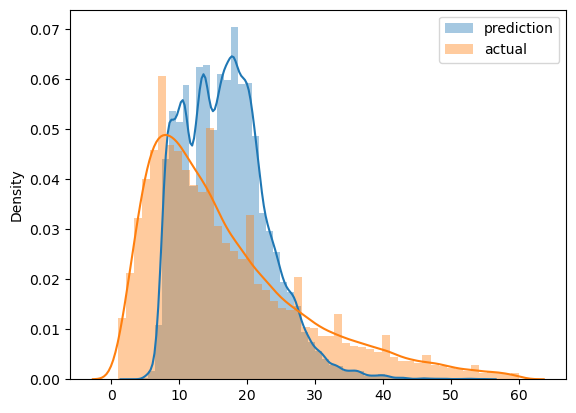

In [11]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [12]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [13]:
df_train = read_dataframe('green_tripdata_2021-01.parquet')
df_val = read_dataframe('green_tripdata_2021-02.parquet')

In [14]:
len(df_train), len(df_val)

(73908, 61921)

In [15]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [16]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [17]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [18]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.758715207192863

In [24]:
lr = Lasso(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

9.233436225720547

In [20]:
lr = Ridge(alpha=0.001)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

7.510860132196885

In [21]:
lr = Lasso(0.01)
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

11.167275941179728

In [22]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,...,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,...,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00,3.933333
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,...,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75,8.750000
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,...,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00,5.966667
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,...,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00,7.083333
7,2,2021-01-01 00:26:31,2021-01-01 00:28:50,N,1.0,75,75,6.0,0.45,3.5,...,0.5,0.96,0.0,None,0.3,5.76,1.0,1.0,0.00,2.316667
